# Linkres cleanup and filtering

### Boilerplate

In [ ]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

### Generate state X and state Y with and without disulfides by doing `KeepSequenceSymmetry` and fixbb design
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.

Record delta sap, delta total score, calculate sap and `wnm_all` correctly this time

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose


def almost_linkres(packed_pose_in=None, **kwargs) -> PackedPose:
    """
    Load pose. Design with linkres x3: state_X_nocys, state_Y_nocys,
    state_XY_nocys. Dump X and Y poses with and without disulfides (4 total).
    Return XY without the disulfides.
    """
    import bz2, os
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed import cluster
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )
    from pyrosetta.rosetta.core.pack.task.operation import (
        IncludeCurrent,
        InitializeFromCommandline,
        ExtraRotamersGeneric,
    )
    from pyrosetta.rosetta.core.pose import Pose
    from pyrosetta.rosetta.protocols.denovo_design.movers import FastDesign
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects
    from pyrosetta.rosetta.protocols.task_operations import LimitAromaChi2Operation

    def sele2str(sele: str, xml_string: str, resis_to_filter: list, pose: Pose) -> str:
        """
        Turn residue selector into list of resis seperated by comma
        @cdemakis @pleung
        """
        import itertools
        from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects

        xml = XmlObjects.create_from_string(xml_string)
        selector = xml.get_residue_selector(sele)
        string = str(
            ",".join(
                map(
                    str,
                    list(
                        itertools.compress(list(selector.apply(pose)), resis_to_filter)
                    ),
                )
            )
        )
        return string

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            ppose = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
    else:
        raise RuntimeError("Need to supply an input")

    pose = io.to_pose(ppose)

    if kwargs["out_path"] == None:
        out_path = os.getcwd()
    else:
        out_path = kwargs["out_path"]
        os.makedirs(os.path.join(os.getcwd(), out_path), exist_ok=True)
    cys_X = scores["disulfide_at_X"].split(",")
    cys_Y = scores["disulfide_at_Y"].split(",")
    unique_cys = set(cys_X + cys_Y)
    # check whether disulfides are orthogonal
    design_resis = [int(x) for x in unique_cys]
    try:
        assert len(unique_cys) in [
            3,
            4,
        ]  # if there are less than 3 CYS or more than 4 we really f'd up at some point
    except AssertionError:
        print("There should be at least 3 unique CYS, but no more than 4")
        return None
    cys1_X, cys2_X = int(cys_X[0]), int(cys_X[1])
    cys1_Y, cys2_Y = int(cys_Y[0]), int(cys_Y[1])
    length = scores["total_length"]
    resis_matrix = [[x, int(x + length)] for x in design_resis]
    target_resis = ",".join(
        [str(x) for row in resis_matrix for x in row]
    )  # flatten matrix
    xml_string = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" />
            <ScoreFunction name="sfxn_design" weights="beta_nov16" >
                <Set use_hb_env_dep="true" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="17" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-1.0" />
                <Set approximate_buried_unsat_penalty_natural_corrections1="true" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-7" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb="1"/>                    
            </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <Chain name="chA" chains="A" />
            <Chain name="chB" chains="B" />
            <Chain name="chC" chains="C" />
            <Chain name="chD" chains="D" />
            <Chain name="AB" chains="A,B" />
            <Chain name="CD" chains="C,D" />
            <Neighborhood name="twosidedY" selector="chD" distance="8.0"/>
            <And name="onesidedY" selectors="chC,twosidedY"/>
            <Index name="designable" resnums="{target_resis}" />
            <Neighborhood name="packable" selector="designable" distance="6.0" include_focus_in_subset="true" />
            <Not name="not_designable" selector="designable" />
            <Not name="not_packable" selector="packable" />
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <OperateOnResidueSubset name="design" selector="designable"> # no CYS; GLY; PRO;
                <RestrictAbsentCanonicalAASRLT aas="ADEFHIKLMNQRSTVWY" />
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="pack" selector="not_designable">
                <RestrictToRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="lock" selector="not_packable">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <RestrictToRepacking name="rtrp" />
            <KeepSequenceSymmetry name="2state" setting="true"/>
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
            <SapScoreMetric name="sap_X" score_selector="AB" />
            <SapScoreMetric name="sap_Y" score_selector="CD" />
            <SapScoreMetric name="sap_A" score_selector="chA" />
            <SapScoreMetric name="sap_B" score_selector="chB" />
            <SapScoreMetric name="sap_C" score_selector="chC" />
            <SapScoreMetric name="sap_D" score_selector="chD" />
        </SIMPLE_METRICS>
        <MOVERS>
            <SetupForSequenceSymmetryMover name="almost_linkres" sequence_symmetry_behaviour="2state" >
                <SequenceSymmetry residue_selectors="AB,CD" />
            </SetupForSequenceSymmetryMover>
            <SwitchChainOrder name="delete_Y" chain_order="12"/>
            <SwitchChainOrder name="delete_X" chain_order="34"/>
            <SwitchChainOrder name="A_only" chain_order="1"/>
            <SwitchChainOrder name="B_only" chain_order="2"/>
            <SwitchChainOrder name="C_only" chain_order="3"/>
            <SwitchChainOrder name="D_only" chain_order="4"/>
            <MutateResidue name="cys1_X" target="{cys1_X}" new_res="CYS" />
            <MutateResidue name="cys2_X" target="{cys2_X}" new_res="CYS" />
            <MutateResidue name="cys1_Y" target="{cys1_Y}" new_res="CYS" />
            <MutateResidue name="cys2_Y" target="{cys2_Y}" new_res="CYS" />
            <ForceDisulfides name="restore_X" 
                scorefxn="sfxn_design"
                disulfides="{cys1_X}:{cys2_X}"
                remove_existing="false"
                repack="true" />
            <ForceDisulfides name="restore_Y" 
                scorefxn="sfxn_design"
                disulfides="{cys1_Y}:{cys2_Y}"
                remove_existing="false"
                repack="true" />
            <FastRelax name="relax" 
                scorefxn="sfxn_design"
                repeats="1" 
                relaxscript="MonomerRelax2019"
                />
            <PackRotamersMover name="repack" 
                scorefxn="sfxn_design"
                task_operations="rtrp"
                />
            <RunSimpleMetrics name="run_metrics" metrics="sap_X,sap_Y,sap_A,sap_B,sap_C,sap_D" override="true" />
        </MOVERS>
        <FILTERS>
            <worst9mer name="pre_wnm_all" rmsd_lookup_threshold="0.4" confidence="0" />
            <MoveBeforeFilter name="wnm_all_X" mover="A_only" filter="pre_wnm_all" confidence="0" />
            <MoveBeforeFilter name="wnm_all_Y" mover="C_only" filter="pre_wnm_all" confidence="0" />
            <ScoreType name="total_score_pose" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
            <MoveBeforeFilter name="tot_score_X" mover="delete_Y" filter="total_score_pose" confidence="0" />
            <MoveBeforeFilter name="tot_score_Y" mover="delete_X" filter="total_score_pose" confidence="0" />
            <MoveBeforeFilter name="tot_score_A" mover="A_only" filter="total_score_pose" confidence="0" />
            <MoveBeforeFilter name="tot_score_B" mover="B_only" filter="total_score_pose" confidence="0" />
            <MoveBeforeFilter name="tot_score_C" mover="C_only" filter="total_score_pose" confidence="0" />
            <MoveBeforeFilter name="tot_score_D" mover="D_only" filter="total_score_pose" confidence="0" />
        </FILTERS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add filter="wnm_all_X" />
            <Add filter="wnm_all_Y" />
            <Add filter="tot_score_X" />
            <Add filter="tot_score_Y" />
            <Add filter="tot_score_A" />
            <Add filter="tot_score_B" />
            <Add filter="tot_score_C" />
            <Add filter="tot_score_D" />
            <Add metrics="sap_X,sap_Y,sap_A,sap_B,sap_C,sap_D" labels="sap_X,sap_Y,sap_A,sap_B,sap_C,sap_D"/>
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(
        target_resis=target_resis,
        cys1_X=cys1_X,
        cys2_X=cys2_X,
        cys1_Y=cys1_Y,
        cys2_Y=cys2_Y,
    )
    # set taskops by extracting them from the xml_string
    xml_obj = XmlObjects.create_from_string(xml_string)
    filters = SingleoutputRosettaScriptsTask(xml_string)
    design_task = xml_obj.get_task_operation("design")
    pack_task = xml_obj.get_task_operation("pack")
    lock_task = xml_obj.get_task_operation("lock")
    linkres_task = xml_obj.get_task_operation("2state")
    # set taskops
    task_factory = pyrosetta.rosetta.core.pack.task.TaskFactory()
    task_factory.push_back(IncludeCurrent())
    task_factory.push_back(InitializeFromCommandline())
    arochi = LimitAromaChi2Operation()
    arochi.include_trp(True)
    task_factory.push_back(arochi)
    ex1_ex2 = ExtraRotamersGeneric()
    ex1_ex2.ex1(True)
    ex1_ex2.ex2(True)
    task_factory.push_back(ex1_ex2)
    task_factory.push_back(design_task)
    task_factory.push_back(pack_task)
    task_factory.push_back(lock_task)
    task_factory.push_back(linkres_task)
    # set movemap
    mm = pyrosetta.rosetta.core.kinematics.MoveMap()
    mm.set_bb(False)
    mm.set_chi(True)
    mm.set_jump(False)
    sfxn_design = xml_obj.get_score_function("sfxn_design")
    fast_design = FastDesign(scorefxn_in=sfxn_design, standard_repeats=1)
    fast_design.cartesian(False)
    fast_design.set_task_factory(task_factory)
    fast_design.set_movemap(mm)
    fast_design.minimize_bond_angles(False)
    fast_design.minimize_bond_lengths(False)
    fast_design.min_type("lbfgs_armijo_nonmonotone")
    fast_design.ramp_down_constraints(False)

    name = file
    basename_no_ext = name.split("/")[-1].replace(".pdb.bz2", "", 1)
    if out_path[-1] != "/":
        out_path += "/"
    else:
        pass
    pose = pose.clone()
    almost_linkres = xml_obj.get_mover("almost_linkres")
    almost_linkres.apply(pose)
    fast_design.apply(pose)

    ref_pose = pose.clone()
    # get state X
    delete_Y = xml_obj.get_mover("delete_Y")
    delete_Y.apply(pose)
    ref_X = pose.clone()
    cys1 = xml_obj.get_mover("cys1_X")
    cys2 = xml_obj.get_mover("cys2_X")
    restore = xml_obj.get_mover("restore_X")
    relax = xml_obj.get_mover("relax")
    repack = xml_obj.get_mover("repack")
    cys1.apply(pose)
    cys2.apply(pose)
    restore.apply(pose)
    repack.apply(pose)
    # dump X
    pose.dump_pdb(os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_X.pdb"))
    scores["X_seq"] = pose.sequence()
    # get rmsd
    relax_X = ref_X.clone()
    relax.apply(relax_X)
    # dump X_nocys
    relax_X.dump_pdb(
        os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_X_nocys.pdb")
    )
    rmsd_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric()
    rmsd_calc.set_rmsd_type(pyrosetta.rosetta.core.scoring.rmsd_atoms(3))
    rmsd_calc.set_run_superimpose(True)
    rmsd_calc.set_comparison_pose(ref_X)
    rmsd = rmsd_calc.calculate(relax_X)
    scores["rmsd_final_X"] = rmsd
    # get state Y
    pose = ref_pose.clone()
    delete_X = xml_obj.get_mover("delete_X")
    delete_X.apply(pose)
    ref_Y = pose.clone()
    cys1 = xml_obj.get_mover("cys1_Y")
    cys2 = xml_obj.get_mover("cys2_Y")
    restore = xml_obj.get_mover("restore_Y")
    cys1.apply(pose)
    cys2.apply(pose)
    restore.apply(pose)
    repack.apply(pose)
    # dump Y
    pose.dump_pdb(os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_Y.pdb"))
    scores["Y_seq"] = pose.sequence()
    # get rmsd
    relax_Y = ref_Y.clone()
    relax.apply(relax_Y)
    # dump Y_nocys
    relax_Y.dump_pdb(
        os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_Y_nocys.pdb")
    )
    rmsd_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric()
    rmsd_calc.set_rmsd_type(pyrosetta.rosetta.core.scoring.rmsd_atoms(3))
    rmsd_calc.set_run_superimpose(True)
    rmsd_calc.set_comparison_pose(ref_Y)
    rmsd = rmsd_calc.calculate(relax_Y)
    scores["rmsd_final_Y"] = rmsd
    assert relax_X.sequence() == relax_Y.sequence()
    scores["final_sequence"] = relax_X.sequence()
    # put in paths to X, Y, X_nocys, Y_nocys
    for suffix in ["X", "Y", "X_nocys", "Y_nocys"]:
        scores[f"{suffix}_path"] = os.path.join(
            os.getcwd(), out_path + f"{basename_no_ext}_{suffix}.pdb"
        )
    Y_resis_sel = xml_obj.get_residue_selector("CD")
    Y_resis = list(Y_resis_sel.apply(ref_pose))
    selector_strings = {
        "chC_resis": sele2str("chC", xml_string, Y_resis, ref_pose),
        "chD_resis": sele2str("chD", xml_string, Y_resis, ref_pose),
        "twosided_Y_resis": sele2str("twosidedY", xml_string, Y_resis, ref_pose),
        "onesided_Y_resis": sele2str("onesidedY", xml_string, Y_resis, ref_pose),
    }
    final_scored = filters(ref_pose.clone())
    final_keys = [
        "wnm_all_X",
        "wnm_all_Y",
        "tot_score_X",
        "tot_score_Y",
        "tot_score_A",
        "tot_score_B",
        "tot_score_C",
        "tot_score_D",
        "sap_X",
        "sap_Y",
        "sap_A",
        "sap_B",
        "sap_C",
        "sap_D",
    ]
    final_update = dict((k, final_scored.pose.scores[k]) for k in final_keys)
    scores.update({**final_update, **selector_strings})
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(ref_pose, key, value)
    ppose = io.to_packed(ref_pose)
    return ppose

### Setup dask, set command line options, make tasks and submit to client for cleanup

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


logging.basicConfig(level=logging.INFO)
selected = os.path.join(os.getcwd(), "05_filter/good.list")
options = {
    "-out:level": "300",
    "-detect_disulf": "false",
    "-precompute_ig": "true",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
}


def create_tasks(selected, options):
    with open(selected, "r") as f:
        for i, pdb_path in enumerate(f):
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["-s"] = pdb_path.rstrip()
            tasks["out_path"] = f"06_states/{int(i / 250)}"
            yield tasks


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

output_path = os.path.join(os.getcwd(), "06_cleanup")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=1020,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(selected, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[almost_linkres])

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig99
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=4G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.129:34375 --nthreads 1 --memory-limit 3.73GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m

<Client: 'tcp://172.16.131.129:34375' processes=0 threads=0, memory=0 B>


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.27+release.7ce64884a77d606b7b667c363527acc846541030 2021-07-09T18:10:05] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


### Look at scores
Hacky function to load JSON-like data

In [2]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "06_cleanup")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,9mer_X,9mer_Y,X_nocys_path,X_path,X_seq,Y_nocys_path,Y_path,Y_seq,abego_str_Y,ala_penalty,...,total_score_Y,twosided_Y_resis,vbuns_X,vbuns_Y,wnm_all_X,wnm_all_Y,wnm_hlx_X,wnm_hlx_Y,cart_bonded_Y,coordinate_constraint_Y
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/06_cleanup/decoys/0000/2021.07.14.20.14.47.330090_388f861217f84bdd81f44044cfff5945.pdb.bz2,0.388903,2.691701,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEDRKEKIRELERKARENTGSDEARKAVKEIATIAAEALKEGDEEV...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEDRKEKIRELERKARENTGSDEARKAVKEIACIAAEALKEGDEEV...,XAAAAAAAAAAAAAAAABBGBAAAAAAAAAAAAAAAAAAAAGBAAA...,1.0,...,-627.371704,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.399102,0.959417,0.115342,0.095169,NaN,NaN
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/06_cleanup/decoys/0000/2021.07.14.20.14.47.330090_d3d3ea6743694ec696c8e6da8d3bd6e2.pdb.bz2,0.330909,2.423884,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TEDEKRELKKVEEKARKAVEEGNTDEVREQLQRALEIAREVGSDEA...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TEDEKRELKKVEEKARKAVEEGNTDEVREQLQRALEIAREVGSDEA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,1.0,...,-626.471313,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.459928,0.629439,0.103229,0.134291,NaN,NaN
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/06_cleanup/decoys/0000/2021.07.14.20.14.47.330090_a77607a894e343d8b32bee8d347c97ba.pdb.bz2,0.336074,2.794657,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DERQKQREEVRKLAEELASKATDEELIKEIKKVAQEAEKLVSKTTD...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DERQKQREEVRKLAEELASKATDEELIKEIKKVAQEAEKLVSKTTD...,XAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAABAB...,1.0,...,-647.802734,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.336712,1.343074,0.139102,0.123228,NaN,NaN
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/06_cleanup/decoys/0000/2021.07.14.20.14.47.330090_9826b41e89534cc0951bda704d074379.pdb.bz2,0.432344,2.336161,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMELLKKAVELAKKNNDDEVAKTIEEAARKIVEALRENNSS...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMELLKKAVELAKKNNDDEVAKTIEEAARKIVEALRENNSS...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAABABA...,1.0,...,-666.169067,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.488022,0.966200,0.107618,0.112947,NaN,NaN
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/06_cleanup/decoys/0000/2021.07.14.20.14.47.330090_61258d92397649aa84b723172352ff0b.pdb.bz2,0.330909,2.287051,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TEDERKELKKILEKVREAVKKGNTDEVREQLQRALEIARESGTEEV...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TEDERKELKKILEKVREAVKKGNTDEVREQLQRALEIARESGTEEV...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,1.0,...,-639.922852,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.382658,1.011527,0.145647,0.121430,NaN,NaN


In [3]:
len(scores_df)

10143

### Add additional metrics

In [4]:
def parent2scaffold(row):
    parent = row["parent"]
    if "THR" in parent:
        scaffold = "THR"
    elif "TH_DHR" in parent:
        scaffold = "TH_DHR"
    elif "KH_" in parent:
        scaffold = "KH_DHR"
    elif "hDHR" in parent:
        scaffold = "hDHR"
    elif "DHR" in parent:
        scaffold = "DHR"
    else:
        raise RuntimeError
    return scaffold


scores_df["scaffold"] = scores_df.apply(parent2scaffold, axis=1)
scores_df.groupby(["scaffold"]).mean()

,9mer_X,9mer_Y,ala_penalty,approximate_buried_unsat_penalty,buns_X,buns_Y,cms_Bc_Y,cms_Y,cms_nB_Y,cms_nc_Y,...,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_X,wnm_all_Y,wnm_hlx_X,wnm_hlx_Y,cart_bonded_Y,coordinate_constraint_Y
scaffold,,,,,,,,,,,,,,,,,,,,,
DHR,0.431181,2.729434,1.451022,57.682548,4.539394,5.121071,222.985810,475.958780,230.538818,246.126459,...,-630.455956,-641.115918,0.0,0.0,0.436461,0.846538,0.113072,0.118254,89.605231,197.616584
TH_DHR,0.436350,3.102731,1.493469,50.759199,3.105951,3.210450,226.481458,429.802240,174.889989,203.353510,...,-579.459652,-591.849192,0.0,0.0,0.507177,0.916912,0.122406,0.128786,136.543620,217.866165
hDHR,0.446304,3.034624,1.455702,52.953008,2.478169,3.224248,240.354110,424.330615,171.046005,239.009647,...,-611.493114,-623.283743,0.0,0.0,0.433504,0.753812,0.113691,0.118823,68.046268,150.233306


In [6]:
def row2state(row):
    state = (
        row["parent"]
        + "_p_"
        + str(int(row["pivot_helix"]))
        + "_s_"
        + str(int(row["shift"]))
    )
    return state


scores_df["state"] = scores_df.apply(row2state, axis=1)

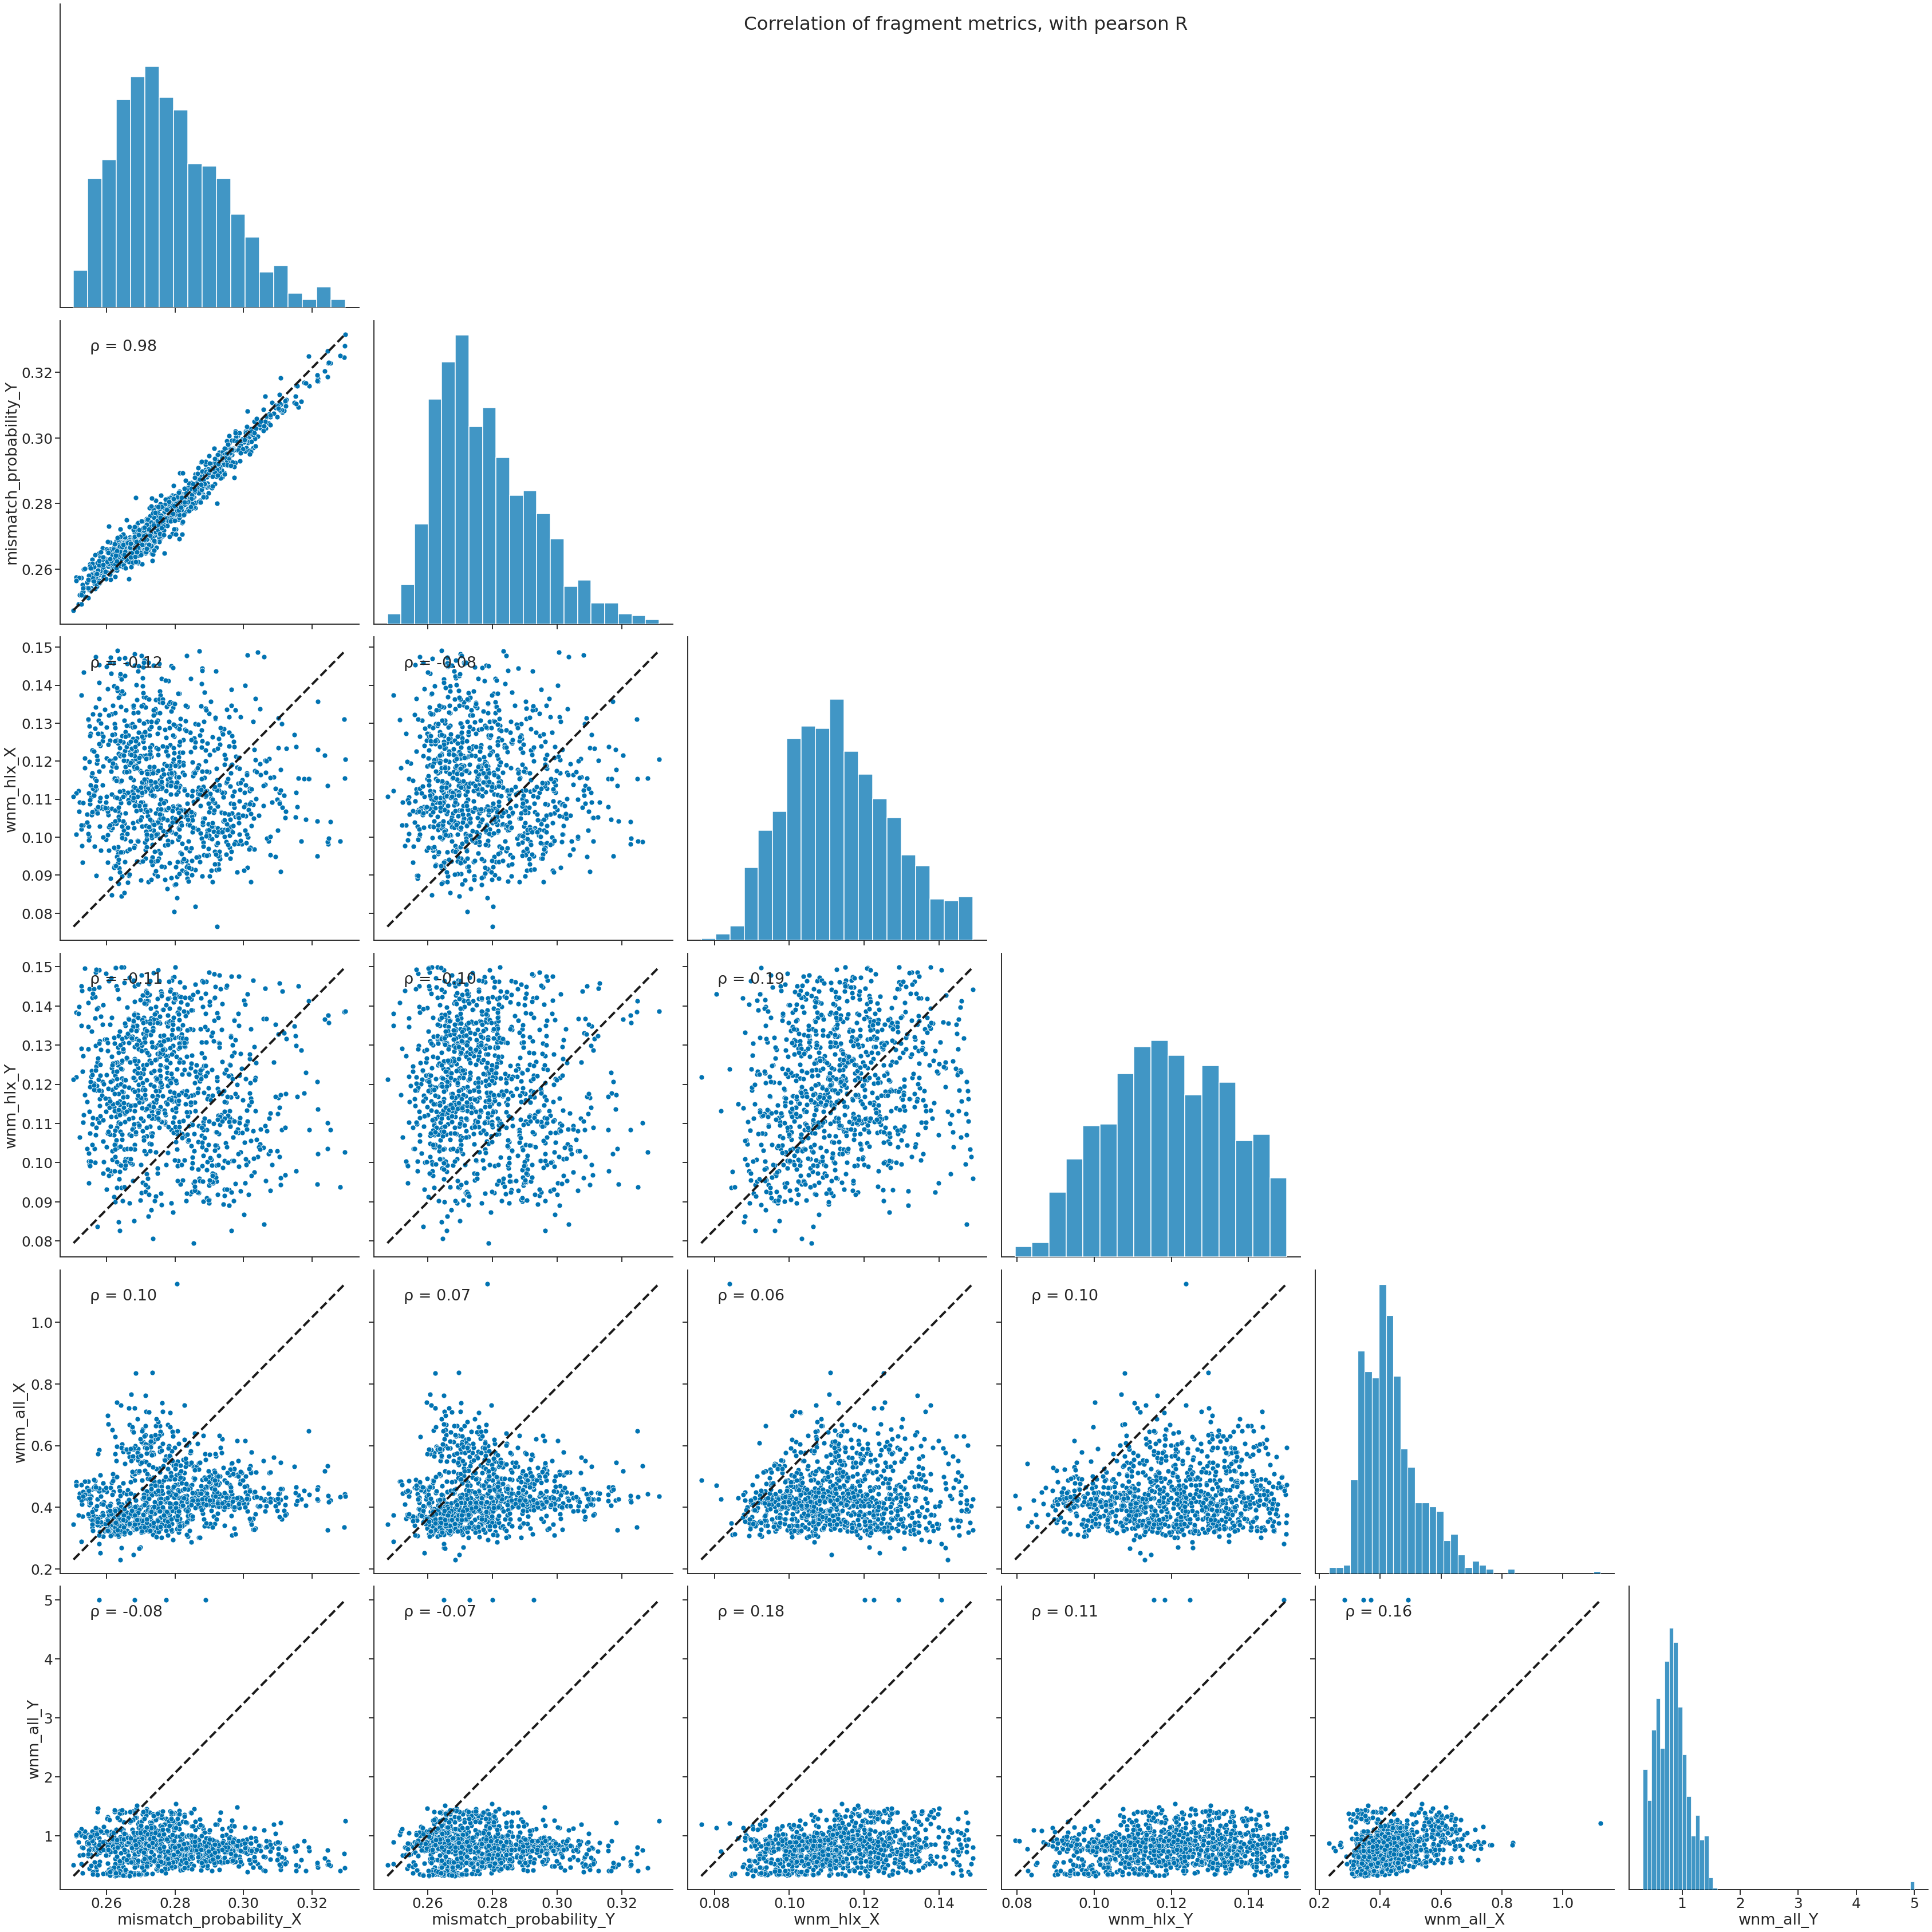

In [13]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)


def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy

    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(0.1, 0.9), xycoords=ax.transAxes)


def plot_unity(xdata, ydata, **kwargs):
    """https://stackoverflow.com/questions/48122019/how-can-i-plot-identity-lines-on-a-seaborn-pairplot"""
    xmin, ymin = (xdata.min(), ydata.min())
    xmax, ymax = (xdata.max(), ydata.max())
    xpoints = np.linspace(xmin, xmax, 100)
    ypoints = np.linspace(ymin, ymax, 100)
    plt.gca().plot(
        xpoints, ypoints, color="k", marker=None, linestyle="--", linewidth=4.0
    )


frag_subset = scores_df[
    [
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_X",
        "wnm_all_Y",
        "parent",
    ]
]

ax = sns.pairplot(
    data=frag_subset.sample(frac=0.1), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of fragment metrics, split by parent")
sns.despine()
plt.savefig("figs/06_correlations_frag_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=frag_subset.sample(frac=0.1), corner=True, height=8)
ax.map_lower(rho)
ax.map_offdiag(plot_unity)
plt.suptitle("Correlation of fragment metrics, with pearson R")
sns.despine()
plt.savefig("figs/06_correlations_frag_pearson.png")

/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


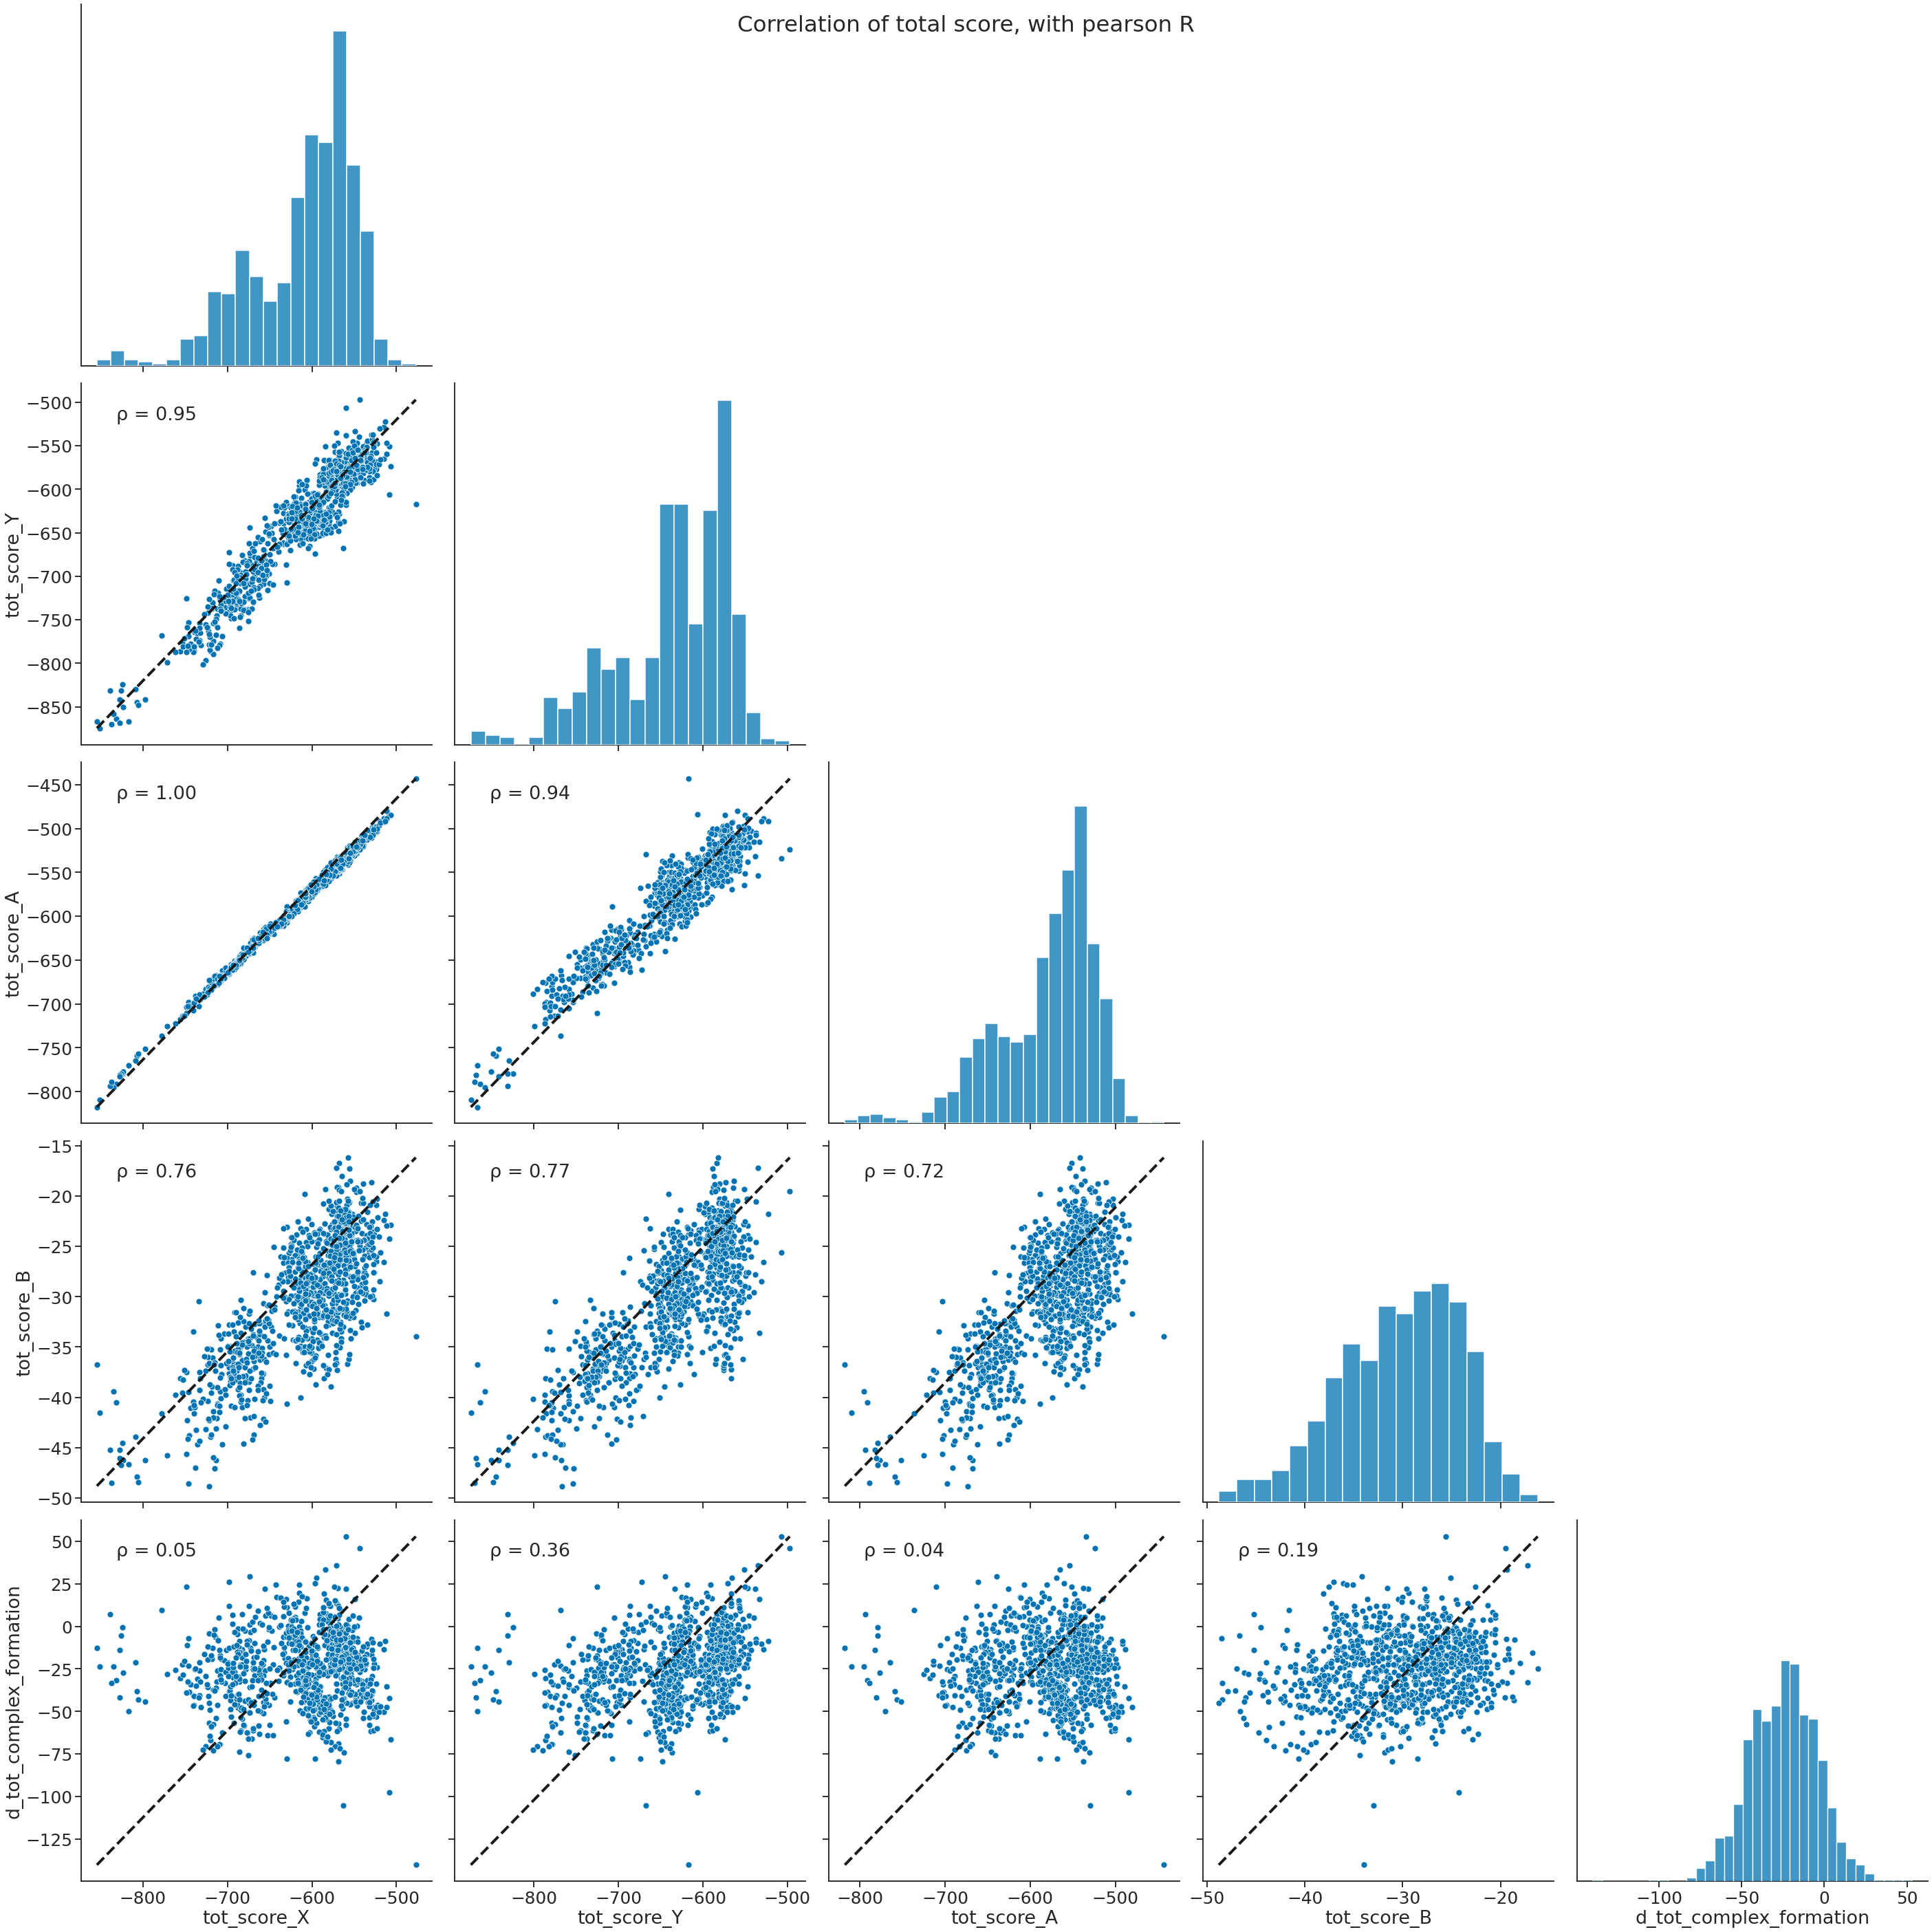

In [14]:
scores_df["d_tot_complex_formation"] = scores_df["tot_score_Y"] - (
    scores_df["tot_score_A"] + scores_df["tot_score_B"]
)

tot_score_subset = scores_df[
    [
        "tot_score_X",
        "tot_score_Y",
        "tot_score_A",
        "tot_score_B",
        "d_tot_complex_formation",
        "parent",
    ]
]

ax = sns.pairplot(
    data=tot_score_subset.sample(frac=0.1), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of total score, split by parent")
sns.despine()
plt.savefig("figs/06_correlations_tot_score_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=tot_score_subset.sample(frac=0.1), corner=True, height=8)
ax.map_lower(rho)
ax.map_offdiag(plot_unity)
plt.suptitle("Correlation of total score, with pearson R")
sns.despine()
plt.savefig("figs/06_correlations_tot_score.png")

/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


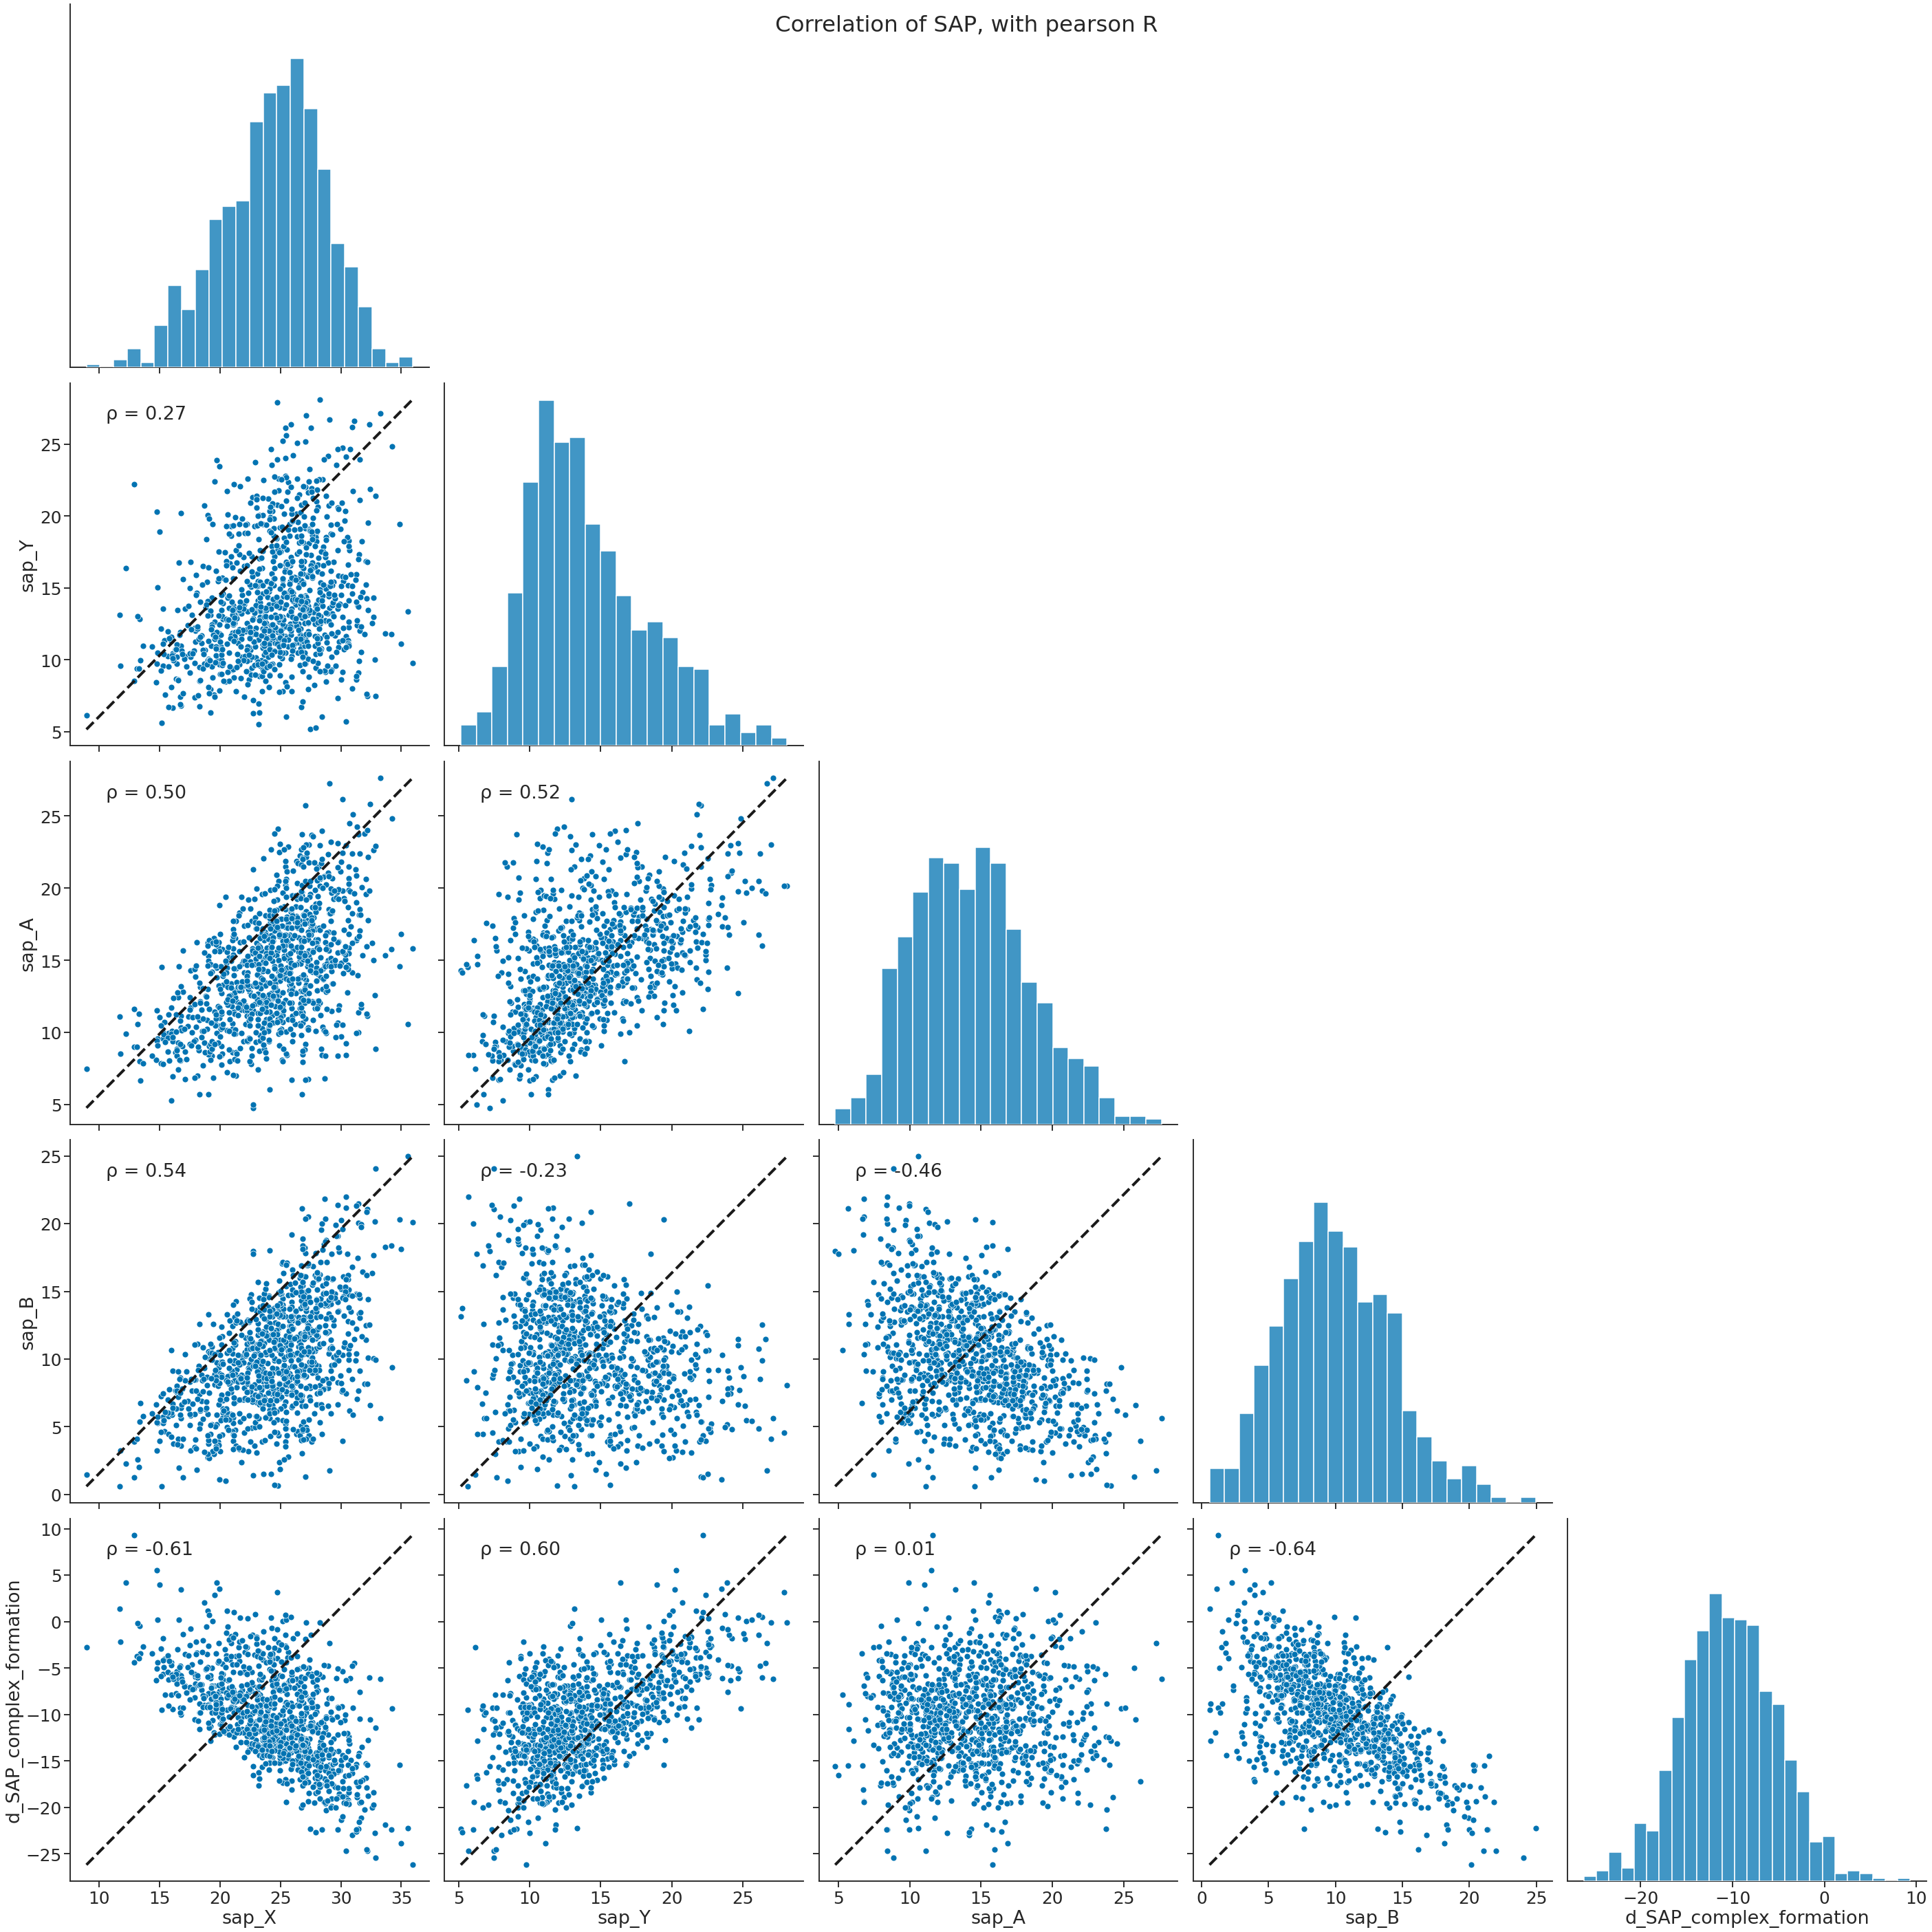

In [15]:
scores_df["d_SAP_complex_formation"] = scores_df["sap_Y"] - (
    scores_df["sap_A"] + scores_df["sap_B"]
)

sap_subset = scores_df[
    [
        "sap_X",
        "sap_Y",
        "sap_A",
        "sap_B",
        "d_SAP_complex_formation",
        "parent",
    ]
]

ax = sns.pairplot(data=sap_subset.sample(frac=0.1), hue="parent", corner=True, height=8)
plt.suptitle("Correlation of SAP, split by parent")
sns.despine()
plt.savefig("figs/06_correlations_SAP_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=sap_subset.sample(frac=0.1), corner=True, height=8)
ax.map_lower(rho)
ax.map_offdiag(plot_unity)
plt.suptitle("Correlation of SAP, with pearson R")
sns.despine()
plt.savefig("figs/06_correlations_SAP.png")

In [17]:
d_high = scores_df[scores_df["sap_A"] < 25]
d_high = d_high[d_high["sap_Y"] < 25]
d_high = d_high[d_high["d_SAP_complex_formation"] < -10]
d_high = d_high[d_high["score_per_res_Y"] < -3]
d_high = d_high[d_high["d_tot_complex_formation"] < 2]
d_high = d_high[d_high["wnm_all_X"] < 0.8]
d_high = d_high[d_high["wnm_all_Y"] < 0.8]

print(len(set(d_high.state.values)))
print(len(d_high))
print(len(set(d_high.parent.values)))
set(scores_df.parent.values) - set(d_high.parent.values)

46
2637
20


{'DHR09', 'hDHR79_5CWP', 'hDHR8_5CWF', 'hDHR9_HFuse', 'hTH_DHR_DN_T6'}

In [18]:
set(d_high.parent.values)

{'DHR07_nocys',
 'DHR08',
 'DHR10',
 'DHR15_nocys',
 'DHR21',
 'DHR24_nocys',
 'DHR26_nocys',
 'DHR39',
 'DHR52_nocys',
 'DHR54',
 'DHR59',
 'TH_DHR_2_NSR',
 'hDHR10_5CWG',
 'hDHR14_5CWH',
 'hDHR14_5H7C',
 'hDHR49_5CWJ',
 'hDHR54_5CWL',
 'hDHR64_5CWM',
 'hDHR71_5CWN',
 'hDHR76_5CWO'}

In [19]:
with open(os.path.join(os.getcwd(), "06_cleanup", "good_binding_delta.list"), "w") as f:
    for i in d_high.index:
        print(i, file=f)

In [ ]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd


def DAN(pdb, scratchpath, index, state):
    import os, subprocess

    def cmd(command, wait=True):
        """@nrbennet @bcov"""
        the_command = subprocess.Popen(
            command,
            shell=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            universal_newlines=True,
        )
        if not wait:
            return
        the_stuff = the_command.communicate()
        return str(the_stuff[0]) + str(the_stuff[1])

    pythonpath = "/software/conda/envs/tensorflow/bin/python"
    script = "/net/software/DeepAccNet/DeepAccNet.py"
    npz = os.path.join(scratchpath, f"{pdb}".split("/")[-1].replace(".pdb", ".npz"))
    to_send = f"""cd {scratchpath}; {pythonpath} {script} -r --pdb {pdb} {npz} """
    cmd(to_send)

    x = np.load(npz)
    lddt = x["lddt"]

    lddt_list = ",".join(map(str, lddt))

    return index, state, lddt_list


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

futures = []

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="16GB",
        queue="long",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-510 workers,
        cluster.adapt(
            minimum=1,
            maximum=510,  
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            for index, row in d_high.iterrows():
                for state in ["X", "Y", "X_nocys", "Y_nocys"]:
                    pdb = row[state + "_path"]
                    future = client.submit(DAN, pdb, scratchpath, index, state)
                    futures.append(future)
            for pending in futures:
                result = pending.result()
                d_high.at[str(result[0]), f"lddt_{result[1]}"] = str(result[2])


### Unused blocks

In [3]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

flags = """
-out:level 300
-precompute_ig 1
-detect_disulf false
-corrections::beta_nov16 true
-holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
-indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5
"""
pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
t = almost_linkres(
    None,
    **{
        "-s": "/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/05_msd_runs_2/4/2f65437ef963b1198d7c01eff28aa08518500dd5cc9bf2cf.pdb.bz2",
        "out_path": "test",
    }
)

core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue ARG:CtermProteinFull 170
core.select.residue_selector.NeighborhoodResidueSelector: {0} [ WARNING ] ################ Cloning pose and building neighbor graph ################
core.select.residue_selector.NeighborhoodResidueSelector: {0} [ WARNING ] Ensure that pose is either scored or has update_residue_neighbors() called
core.select.residue_selector.NeighborhoodResidueSelector: {0} [ WARNING ] before using NeighborhoodResidueSelector for maximum performance!
core.select.residue_selector.NeighborhoodResidueSelector: {0} [ WARNING ] ##########################################################################
core.chemical.AtomICoor: {0} [ WARNING ] IcoorAtomID::atom_id(): Cannot get atom_id for POLYMER_LOWER of residue LEU 1.  Returning BOGUS ID instead.
core.conformation.Residue: {0} [ WARNING ] missing an atom: 1  H   that depends on a nonexistent polymer connection!
core.conformation.Residue: {0} [ WARNIN